In [1]:
import pymystem3, pymorphy2
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import seaborn as sns
import scipy.stats as st
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from gensim.models.word2vec import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Data Uploading

In [2]:
df_train = pd.read_csv('train.csv', sep=';', index_col='id')

In [3]:
df_test = pd.read_csv('test.csv', sep=';', index_col='id')

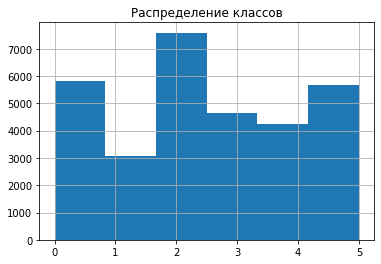

In [4]:
df_train['target'].hist(bins=len(set(df_train['target'])))
plt.title('Распределение классов');

Метки классов:
- **[0]** Строительство, недвижимость
- **[1]**  Медицина, фармацевтика
- **[2]**  Информационные технологии, интернет, телеком
- **[3]** Бухгалтерия, управленческий учет, финансы предприятия
- **[4]** Туризм, гостиницы, рестораны
- **[5]** Транспорт, логистика

## Text Preprocecssing

In [5]:
# Список значимых частей речи. 
# Они нам потом понадобятся в немного другом виде. Так что сделаем словарь. чтобы два раза не вставать.

morph = pymorphy2.MorphAnalyzer()

conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}
            
tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy_fast(text, need_pos=False):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    with open("mystopwords.txt", encoding="utf-8") as file: 
        stop_words = file.read()
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None and pv[0].score >= 0.20:
                if pv[0].normal_form != 'быть' and \
                len(pv[0].normal_form) > 2 and \
                pv[0].normal_form not in stop_words and \
                pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

normalizePymorphy_fast('слон слон слон в посудной лавке дружный коллектив арарара')

['слон', 'слон', 'слон', 'посудный', 'лавка']

In [6]:
%%time
df_train['NText'] = df_train['text'].map(lambda x:' '.join(normalizePymorphy_fast(x)))

CPU times: user 2min, sys: 596 ms, total: 2min
Wall time: 2min


In [7]:
df_train.iloc[55].values

array(['<p>Если ты любишь писать качественный код, постоянно учишься новому, отстаиваешь свою точку зрения (и уважаешь чужую), хочешь принять самое непосредственное участие в проектировании продукта - ждем тебя в команде WinWin Technologies!</p> <p>Мы создаем IT-решения для сферы недвижимости на базе amoCRM и очень быстро развиваемся.</p> <p>Что нужно будет делать:</p> <ul> <li> <p>Поддерживать и выпускать новые версии существующих решений для наших клиентов;</p> </li> <li> <p>Участвовать в проектировании и создании новых фич;</p> </li> <li> <p>Работать в команде;</p> </li> <li> <p>Изучать и применять на практике самые современные подходы к разработке ПО.</p> </li> </ul> <p>Что ты получишь, работая у нас (помимо денег конечно)</p> <ul> <li> <p>опыт работы с современным стеком технологий</p> </li> <li> <p>возможность дальнейшего развития вместе с компанией</p> </li> <li> <p>офис в центре города</p> </li> <li> <p>фан и удовольствие от работы в молодой команде.</p> </li> </ul> <p>Ты нам п

In [8]:
%%time
df_test['NText'] = df_test['text'].map(lambda x:' '.join(normalizePymorphy_fast(x, need_pos=False)))

CPU times: user 1min 50s, sys: 620 ms, total: 1min 51s
Wall time: 1min 51s


In [9]:
df_test.iloc[-3].values

array(['<strong>Обязанности:</strong> <ul> <li>Монтаж мягкой рулонной кровли на объекте работодателя (МЗиК);</li> <li>Наплавка гидроизоляционного материал</li> </ul> <strong>Требования:</strong> <ul> <li>Опыт работы кровельщиком по устройству мягкой рулонной кровли;</li> <li>Ответственность, исполнительность.</li> </ul> <strong>Условия:</strong> <ul> <li>Работа на территории объекта г.Воронеж.</li> <li>Оформление по ТК РФ.</li> <li>График работы: 5/2. Суббота, воскресенье-выходной. Режим работы: 8.00.-17.00.</li> <li>З/плата: окладно - премиальная (без задержек, белая, 2 раза в месяц) - обсуждается с Начальником участка.</li> </ul>',
       'монтаж мягкий рулонный кровля объект работодатель мзик наплавка гидроизоляционный материал кровельщик мягкий рулонный кровля ответственность исполнительность территория объект воронеж режим окладный премиальный задержка белый месяц обсуждаться начальник участок'],
      dtype=object)

## Text Vectorizing

In [23]:
cv = CountVectorizer()

In [24]:
tfidf = TfidfVectorizer()

### Word2Vec

In [25]:
import re

sentence_split_by_dot_pattern = r'(?<!\s\w\d\.)(?<!\w\.\w\.)(?<=[….?!])[\s+\n+]\s*(?=[\w\"\'«]|<\/?\s*p\s*>|-(?=\s*\w+))'
sentence_split_pattern = sentence_split_by_dot_pattern \
                         + r'|(?<![….!?]\s<\/p>)[\s+\n+]\s*(?=<\s*p\s*>|<\s*br\s*\/?>)|[….?!](?=<\/?\s*p\s*>|<br\s*\/?>)'
word_split_pattern = r"(?P<word>(?:(?!_)(?:[\w/]|(?<=\w)[-'.](?=\w)))+)"
sentence_split_regexp = re.compile(sentence_split_pattern, flags=re.UNICODE)
word_split_regexp = re.compile(word_split_pattern, flags=re.UNICODE)

def split_text_into_part(text, part_regexp):
    return [text for i, text in
            enumerate(part_regexp.split(text))]

def split_text_into_sentences(text):
    return split_text_into_part(text, sentence_split_regexp) 

In [26]:
morph2 = pymorphy2.MorphAnalyzer()

conv_pos2 = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}
          
nones2 = {} # Кеш незначимых слов.
tmp_dict2 = {} # Кеш значимых слов.

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy_sentences(text, need_pos=False):
    output = []
    # Делим на предложения самым страшным из возможных образов.
    sentences = split_text_into_sentences(text)
    for sentence in sentences:
        tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', sentence)
        with open("mystopwords.txt", encoding="utf-8") as file: 
            stop_words = file.read()
        words = []
        for t in tokens:
            # Если токен уже был закеширован, быстро возьмем результат из него.
            if t in tmp_dict2.keys():
                words.append(tmp_dict2[t])
            # Аналогично, если он в кеше незначимых слов.
            elif t in nones2.keys():
                pass
            # Слово еще не встретилось, будем проводить медленный морфологический анализ.
            else:
                pv = morph2.parse(t)
                if pv[0].tag.POS != None and pv[0].score >= 0.20:
                    if pv[0].normal_form != 'быть' and \
                    len(pv[0].normal_form) > 2 and \
                    pv[0].normal_form not in stop_words and \
                    pv[0].tag.POS in conv_pos2.keys():
                        if need_pos:
                            word = pv[0].normal_form+"_"+conv_pos2[pv[0].tag.POS]
                        else:
                            word = pv[0].normal_form
                        # Отправляем слово в результат, ...
                        words.append(word)
                        # ... и кешируем результат его разбора.
                        tmp_dict2[t] = word
                    else:
                        # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                        nones2[t] = ""
        output.append(words)
        # Берем предложения не менее чем из 2 слов.
        output = [s for s in output if len(s) > 1]
                    
    return output

normalizePymorphy_sentences(df_train['text'][55])

[['любить',
  'качественный',
  'код',
  'учиться',
  'новый',
  'отстаивать',
  'точка',
  'зрение',
  'уважать',
  'чужой',
  'непосредственный',
  'участие',
  'проектирование',
  'продукт',
  'ждать',
  'команда'],
 ['создавать', 'it-решение', 'сфера', 'недвижимость', 'база', 'развиваться'],
 ['новое', 'версия', 'существующий', 'решение', 'клиент'],
 ['проектирование', 'создание', 'новый'],
 ['практика', 'современный', 'подход', 'разработка'],
 ['получить', 'работать', 'деньга'],
 ['современный', 'стек', 'технология'],
 ['дальнейший', 'развитие'],
 ['офис', 'центр'],
 ['удовольствие', 'команда'],
 ['разработка', 'приложение'],
 ['знакомство', 'frontend-фреймворок'],
 ['чистый', 'понятный', 'код', 'покрыть', 'тест', 'документация'],
 ['искать',
  'разработчик',
  'разный',
  'уровень',
  'чувствовать',
  'уверенность',
  'использование',
  'технология',
  'писать']]

In [27]:
all_sentences = []
for text in tqdm(np.concatenate([df_train['text'].values, df_test['text'].values])):
    all_sentences.extend(normalizePymorphy_sentences(text))

100%|██████████| 62127/62127 [04:42<00:00, 220.27it/s]


In [28]:
all_sentences[9]

['офис', 'минута', 'алексеевский']

In [29]:
phrases = Phrases(sentences=all_sentences, min_count=5, threshold=10)
bigram = Phraser(phrases)

In [30]:
for index, sentence in enumerate(all_sentences):
    all_sentences[index] = bigram[sentence]

In [31]:
%%time

num_features = 500  
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 2     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 2        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

w2v_model = Word2Vec(all_sentences, workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 1min 11s, sys: 195 ms, total: 1min 11s
Wall time: 39.2 s


In [32]:
import random
def shuffle_corpus(sentences):
    shuffled = list(sentences)
    random.shuffle(shuffled)
    return shuffled

In [34]:
w2v_model.build_vocab(sentences=shuffle_corpus(all_sentences),update=True)

In [35]:
w2v_model.train(sentences=shuffle_corpus(all_sentences), epochs=5, total_examples=w2v_model.corpus_count)

(16200297, 17335635)

In [36]:
w2v_model.init_sims(replace=True)

In [525]:
w2v_model.most_similar('программист')
# [('разработчик', 0.465656042098999),
#  ('тестировщик', 0.32677173614501953),
#  ('аналитик', 0.3087739944458008),
#  ('системный_аналитик', 0.2941707968711853),
#  ('инженер-программист', 0.2872644364833832),
#  ('консультант', 0.27946096658706665),
#  ('верстальщик', 0.27530044317245483),
#  ('инженер', 0.2670886516571045),
#  ('команда', 0.2649926543235779),
#  ('бизнес-аналитик', 0.2639397084712982)]

[('разработчик', 0.465656042098999),
 ('тестировщик', 0.32677173614501953),
 ('аналитик', 0.3087739944458008),
 ('системный_аналитик', 0.2941707968711853),
 ('инженер-программист', 0.2872644364833832),
 ('консультант', 0.27946096658706665),
 ('верстальщик', 0.27530044317245483),
 ('инженер', 0.2670886516571045),
 ('команда', 0.2649926543235779),
 ('бизнес-аналитик', 0.2639397084712982)]

In [526]:
w2v_model.most_similar('разработчик')
# [('программист', 0.465656042098999),
#  ('тестировщик', 0.35366004705429077),
#  ('системный_аналитик', 0.35111236572265625),
#  ('разработка', 0.350646436214447),
#  ('команда', 0.345970094203949),
#  ('проект', 0.3452380895614624),
#  ('тестирование', 0.3441500663757324),
#  ('бизнес-аналитик', 0.33008265495300293),
#  ('разработчик_тестировщик', 0.32934415340423584),
#  ('аналитик', 0.32528698444366455)]

[('программист', 0.465656042098999),
 ('тестировщик', 0.35366004705429077),
 ('системный_аналитик', 0.35111236572265625),
 ('разработка', 0.350646436214447),
 ('команда', 0.345970094203949),
 ('проект', 0.3452380895614624),
 ('тестирование', 0.3441500663757324),
 ('бизнес-аналитик', 0.33008265495300293),
 ('разработчик_тестировщик', 0.32934415340423584),
 ('аналитик', 0.32528698444366455)]

In [123]:
w2v_model.corpus_total_words

3467127

In [45]:
index2word_set = set(w2v_model.wv.index2word)

def text_to_vec(text):
    text_vec = np.zeros((w2v_model.vector_size,), dtype="float32")
    n_words = 0

    for word in text.split():
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, w2v_model[word]) 
    
    if n_words != 0:
        text_vec /= n_words
        
    return text_vec

#text_to_vec(df_train['NText'][0])

## Clustering

In [484]:
from umap import UMAP

In [488]:
umap=UMAP(n_components=2)
umaped_vct=umap.fit_transform(X)

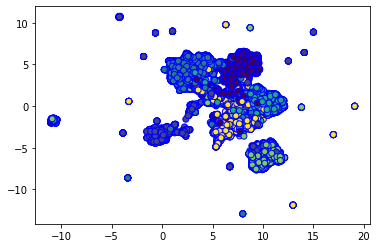

In [489]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', c=y)
plt.show()

In [490]:
%%time
# Кластеризуем, в среднем по два слова на кластер.
vecs = w2v_model.wv.vectors
clust_no = int(len(vecs)/2)
km_clustering = KMeans(n_clusters=clust_no, verbose=50)
clusters = km_clustering.fit_predict(vecs)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 1566.3793
start iteration
done sorting
end inner loop
Iteration 1, inertia 1551.6359
start iteration
done sorting
end inner loop
Iteration 2, inertia 1548.407
start iteration
done sorting
end inner loop
Iteration 3, inertia 1547.5001
start iteration
done sorting
end inner loop
Iteration 4, inertia 1547.0323
start iteration
done sorting
end inner loop
Iteration 5, inertia 1546.7906
start iteration
done sorting
end inner loop
Iteration 6, inertia 1546.6661
start iteration
done sorting
end inner loop
Iteration 7, inertia 1546.6113
start iteration
done sorting
end inner loop
Iteration 8, inertia 1546.5619
start iteration
done sorting
end inner loop
Iteration 9, inertia 1546.5236
start iteration
done sorting
end inner loop
Iteration 10, inertia 1546.5148
start iteration
done sorting
end inner loop
Iteration 11, inertia 1546.5148
center shift 0.000000e+00 within tolerance 2.380208e-07
Initialization comp

Iteration 11, inertia 1552.275
start iteration
done sorting
end inner loop
Iteration 12, inertia 1552.2677
start iteration
done sorting
end inner loop
Iteration 13, inertia 1552.266
start iteration
done sorting
end inner loop
Iteration 14, inertia 1552.2623
start iteration
done sorting
end inner loop
Iteration 15, inertia 1552.258
start iteration
done sorting
end inner loop
Iteration 16, inertia 1552.258
center shift 0.000000e+00 within tolerance 2.380208e-07
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 1567.4761
start iteration
done sorting
end inner loop
Iteration 1, inertia 1551.6378
start iteration
done sorting
end inner loop
Iteration 2, inertia 1548.5444
start iteration
done sorting
end inner loop
Iteration 3, inertia 1547.5548
start iteration
done sorting
end inner loop
Iteration 4, inertia 1546.8595
start iteration
done sorting
end inner loop
Iteration 5, inertia 1546.5814
start iteration
done sorting
end inner loop
Iteration 6, inert

In [597]:
clust_no=537
words = w2v_model.wv.index2word

words_sorted = sorted(zip(clusters, words), key= lambda x:x[0])
print([word[1] for word in words_sorted if word[0]==clust_no])

[]


In [519]:
# unique, counts = np.unique(clusters, return_counts=True)
# dict(zip(unique, counts))

In [523]:
# Посчитаем координаты центроидов.
cur_clust = words_sorted[0][0]
cur_coord = np.array(w2v_model[words_sorted[0][1]])
cur_count = 1
clust_coord = []

for i, word in enumerate(words_sorted[1:]):
    if cur_clust == words_sorted[i+1][0]:
        cur_coord += w2v_model[words_sorted[i+1][1]]
        cur_count += 1
    else:
        clust_coord.append(cur_coord/cur_count)
        cur_clust = words_sorted[i+1][0]
        cur_coord = np.array(w2v_model[words_sorted[i+1][1]])
        cur_count = 1
        
clust_coord.append(cur_coord/cur_count)

In [541]:
# Эта функция берет центры кластеров вместо слов.
words_d = {w[1]:w[0] for w in words_sorted}

def text_to_vec_centr(text):
    text_vec = np.zeros((w2v_model.vector_size,), dtype="float32")
    n_words = 0
    
    for word in text.split():
        if word in words_d.keys():
            n_words = n_words + 1
            text_vec = np.add(text_vec, clust_coord[words_d[word]]) 
        else:
            try:
                text_vec = np.add(text_vec, w2v_model[word]) 
                n_words = n_words + 1
            except Exception:
                pass
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

#text_to_vec_centr(df_train['NText'][0])

In [542]:
# Строим вектора для слов.
vect2 = []
for text in tqdm(df_train['NText']):
    vect2.append(text_to_vec_centr(text))

100%|██████████| 31063/31063 [00:04<00:00, 7372.86it/s]


In [543]:
# Посмотрим как распределятся документы при таком подходе.
umap2=UMAP()
umaped_vct2=umap2.fit_transform(vect2)

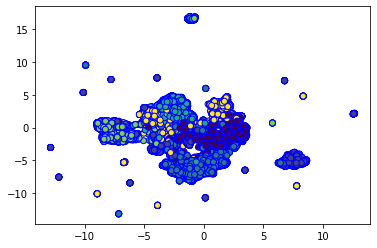

In [544]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct2[:, 0], umaped_vct2[:, 1], edgecolor='b', c=y)
plt.show()

In [561]:
%%time
cluster_space_size = 50
km_clustering = KMeans(n_clusters=cluster_space_size)
clusters2 = km_clustering.fit_predict(vecs)

CPU times: user 1min 25s, sys: 1min 27s, total: 2min 53s
Wall time: 46.7 s


In [565]:
 # Эта функция берет для документа количество слов по кластерам..
words_d2 = {w[1]:w[0] for w in words_sorted}

def text_to_centoids(text):
    text_vec = np.zeros((cluster_space_size,), dtype="float32")
    n_words = 0

    for word in text.split():
        if word in words_d2.keys():
            n_words = n_words + 1
            text_vec[clust_coord[words_d2[word]]] += 1
    
    if np.sum(text_vec) != 0:
        text_vec /= np.sum(text_vec)
    return text_vec

#text_to_vec_centr(df_train['NText'][0])

In [567]:
#clust_coord[words_d['процесс']]

In [571]:
# Эта функция берет для документа количество слов по кластерам..
words_d3 = {w[1]:w[0] for w in sorted(zip(clusters2, words), key= lambda x:x[0])}

def text_to_centoids(text):
    text_vec = np.zeros((cluster_space_size,), dtype="float32")
    n_words = 0

    for word in text.split():
        if word in words_d3.keys():
            text_vec[words_d3[word]] += 1
    
    if np.sum(text_vec) != 0:
        text_vec /= np.sum(text_vec)
    return text_vec

#text_to_vec_centr(df_train['NText'][0])

In [572]:
# Строим вектора для слов.
vect3 = []
for text in tqdm(df_train['NText']):
    vect3.append(text_to_centoids(text))

100%|██████████| 31063/31063 [00:09<00:00, 3431.93it/s]


In [619]:
# Посмотрим как распределятся документы при таком подходе.
umap3=UMAP()
umaped_vct3=umap2.fit_transform(vect3)

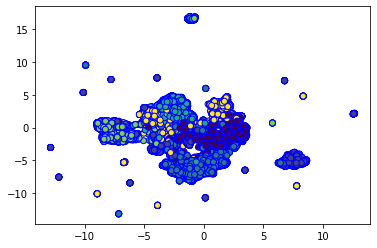

In [620]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct2[:, 0], umaped_vct2[:, 1], edgecolor='b', c=y)
plt.show()

## Topic Modeling

In [105]:
from gensim import corpora, models

In [449]:
# сохранение текста в формате gensim библиотеки (словарь-корпус)
dictionary = corpora.Dictionary([text.split(' ') for text in df_train['NText']])
dictionary.save('jobs.dict')
corpus = [dictionary.doc2bow(text.split(' ')) for text in (df_train['NText'])]
corpora.MmCorpus.serialize('jobs.mm', corpus)

In [450]:
n = 70
a = 0.8
model = models.ldamodel.LdaModel(corpus, num_topics=n, id2word=dictionary, alpha=a, random_state=0, passes=3)

In [451]:
# import pyLDAvis.gensim
# pyLDAvis.enable_notebook()
# pyLDAvis.gensim.prepare(model, corpus, dictionary)

In [452]:
%matplotlib inline

In [453]:
# топ тематик по 10 словам каждой темы
import networkx as nx
G = nx.Graph()
for i in range(n):
    topic_l = 'topic_' + str(i)
    terms = [t for t, v in model.show_topic(i, 10)]
    for term in terms:
        G.add_edge(topic_l, term)
pos = nx.spring_layout(G)

(-1, 1)

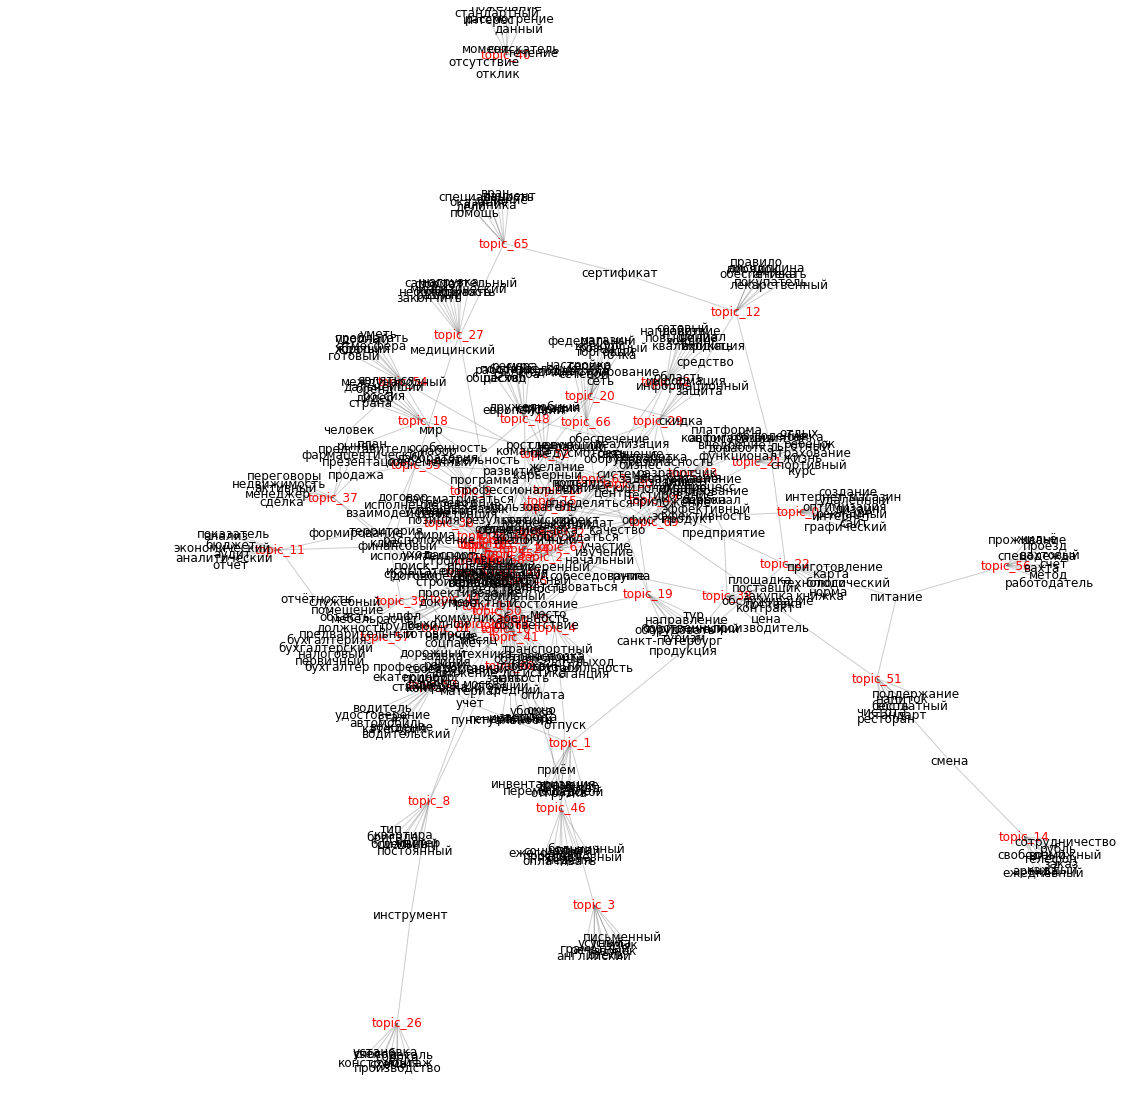

In [454]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
plt.figure(figsize=(20, 20))
f = G.subgraph([topic for topic,_ in pos.items() if 'topic_' in topic])
nx.draw_networkx_labels(f, pos, font_color='r')
f = G.subgraph([topic for topic,_ in pos.items() if 'topic_' not in topic])
nx.draw_networkx_labels(f, pos)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), alpha=0.2)
plt.axis('off')
plt.ylim(-1, 1)
plt.xlim(-1, 1)

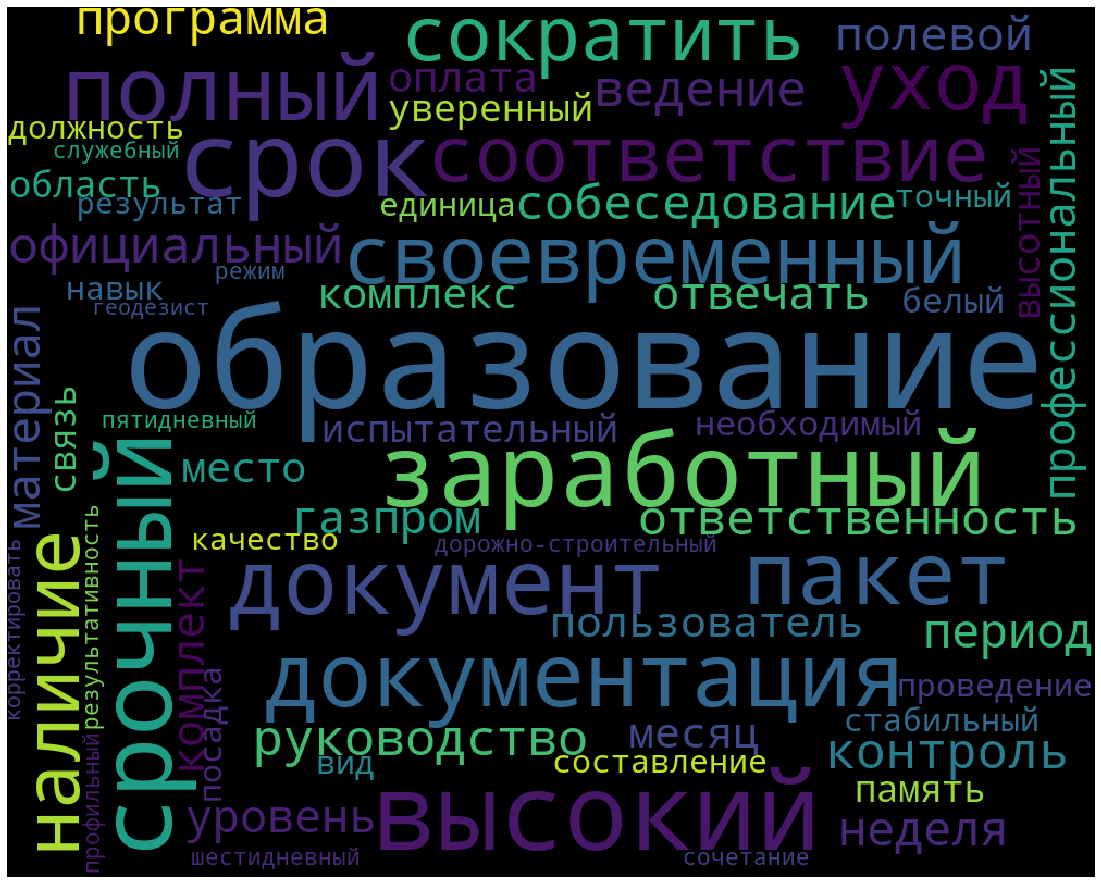

In [455]:
import wordcloud
NUM_CLASS = 5

words = model.show_topic(NUM_CLASS, 64)
wc = wordcloud.WordCloud(width=1000, height=800, margin=2)
wc.generate_from_frequencies({x: y for x,y in words})
plt.figure(figsize=(20, 16))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [456]:
# добавляем фичи к текстам
from gensim import matutils
topics = matutils.corpus2dense(model[corpus], num_terms=model.num_topics)

In [457]:
topics = topics.T

In [458]:
topics.shape

(31063, 70)

In [459]:
topics[77]

array([0.        , 0.        , 0.        , 0.        , 0.01008217,
       0.01864496, 0.01193061, 0.        , 0.01003246, 0.01062871,
       0.01085656, 0.        , 0.01309931, 0.01008725, 0.        ,
       0.        , 0.0110226 , 0.01220648, 0.        , 0.02083411,
       0.        , 0.02740225, 0.01213276, 0.01537156, 0.01113956,
       0.02709923, 0.02166106, 0.        , 0.04581813, 0.02233657,
       0.0195093 , 0.        , 0.        , 0.01183762, 0.01027364,
       0.        , 0.04071731, 0.        , 0.        , 0.0124363 ,
       0.        , 0.01981879, 0.02195921, 0.        , 0.0119701 ,
       0.01195352, 0.0100765 , 0.01037644, 0.05542303, 0.        ,
       0.01657412, 0.        , 0.        , 0.02565503, 0.        ,
       0.03149363, 0.01153355, 0.01886979, 0.01207161, 0.01113046,
       0.01179851, 0.        , 0.01232008, 0.        , 0.        ,
       0.        , 0.        , 0.01029898, 0.0110128 , 0.03094742],
      dtype=float32)

## Modeling

In [558]:
y = df_train['target']

In [585]:
w2v_dict = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))
tfidf2 = TfidfVectorizer(w2v_dict).fit(np.concatenate((df_train['NText'].values, df_test['NText'].values)))

In [586]:
X = tfidf2.transform(df_train['NText'])
X.shape

(31063, 42247)

In [587]:
#X = np.array([text_to_vec(text) for text in df_train['NText']])

In [588]:
from scipy import sparse
As = sparse.csr_matrix(topics)
As.shape

(31063, 70)

In [589]:
from scipy.sparse import hstack
X = hstack((X, As))

In [590]:
X.shape

(31063, 42317)

In [591]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [592]:
for c in [0.1, 0.2, 0.3, 0.8, 1, 2, 10]:
    model = LinearSVC(C=c)
    model.fit(X_train, y_train)
    print('Linear SVC: C =', c, ', score =', accuracy_score(y_test, model.predict(X_test)))    

Linear SVC: C = 0.1 , score = 0.9392638695138963
Linear SVC: C = 0.2 , score = 0.9416246378366777
Linear SVC: C = 0.3 , score = 0.9419465607897843
Linear SVC: C = 0.8 , score = 0.9392638695138963
Linear SVC: C = 1 , score = 0.9381907930035411
Linear SVC: C = 2 , score = 0.9340057946131559
Linear SVC: C = 10 , score = 0.9273527202489538


In [593]:
ovo_lsvc = OneVsOneClassifier(LinearSVC())
ovo_lr = OneVsOneClassifier(LogisticRegression())

In [594]:
model = LinearSVC(C=1, random_state=0)
model.fit(X_train, y_train)
predict = model.predict(X_test)
print(classification_report(y_test, predict))
print(confusion_matrix(y_test, predict))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1739
           1       0.98      0.94      0.95       930
           2       0.92      0.96      0.94      2273
           3       0.95      0.91      0.93      1375
           4       0.97      0.96      0.96      1300
           5       0.93      0.93      0.93      1702

    accuracy                           0.94      9319
   macro avg       0.94      0.94      0.94      9319
weighted avg       0.94      0.94      0.94      9319

[[1605    2   62   15    5   50]
 [  10  870   22    5   12   11]
 [  38    8 2187   23    5   12]
 [  26    2   52 1254    9   32]
 [   6    5   28    7 1244   10]
 [  57    5   36   14    7 1583]]


Метки классов:
- **[0]** Строительство, недвижимость
- **[1]**  Медицина, фармацевтика
- **[2]**  Информационные технологии, интернет, телеком
- **[3]** Бухгалтерия, управленческий учет, финансы предприятия
- **[4]** Туризм, гостиницы, рестораны
- **[5]** Транспорт, логистика

In [595]:
score = []
cv = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    score.append(acc)
    print('model:', acc)
    
print('mean accuracy:', np.mean(score))

TypeError: only integer scalar arrays can be converted to a scalar index

## Predict

In [475]:
# сохранение текста в формате gensim библиотеки (словарь-корпус)
dictionary_test = corpora.Dictionary([text.split(' ') for text in df_test['NText']])
dictionary_test.save('jobs_test.dict')
corpus_test = [dictionary_test.doc2bow(text.split(' ')) for text in (df_test['NText'])]
corpora.MmCorpus.serialize('jobs_test.mm', corpus_test)

In [476]:
model_test = models.ldamodel.LdaModel(corpus_test, num_topics=n, id2word=dictionary_test, alpha=a)

In [481]:
# топ тематик по словам каждой темы
import networkx as nx
G = nx.Graph()
for i in range(n):
    topic_l = 'topic_' + str(i)
    terms = [t for t, v in model_test.show_topic(i, 10)]
    for term in terms:
        G.add_edge(topic_l, term)
pos = nx.spring_layout(G)

(-1, 1)

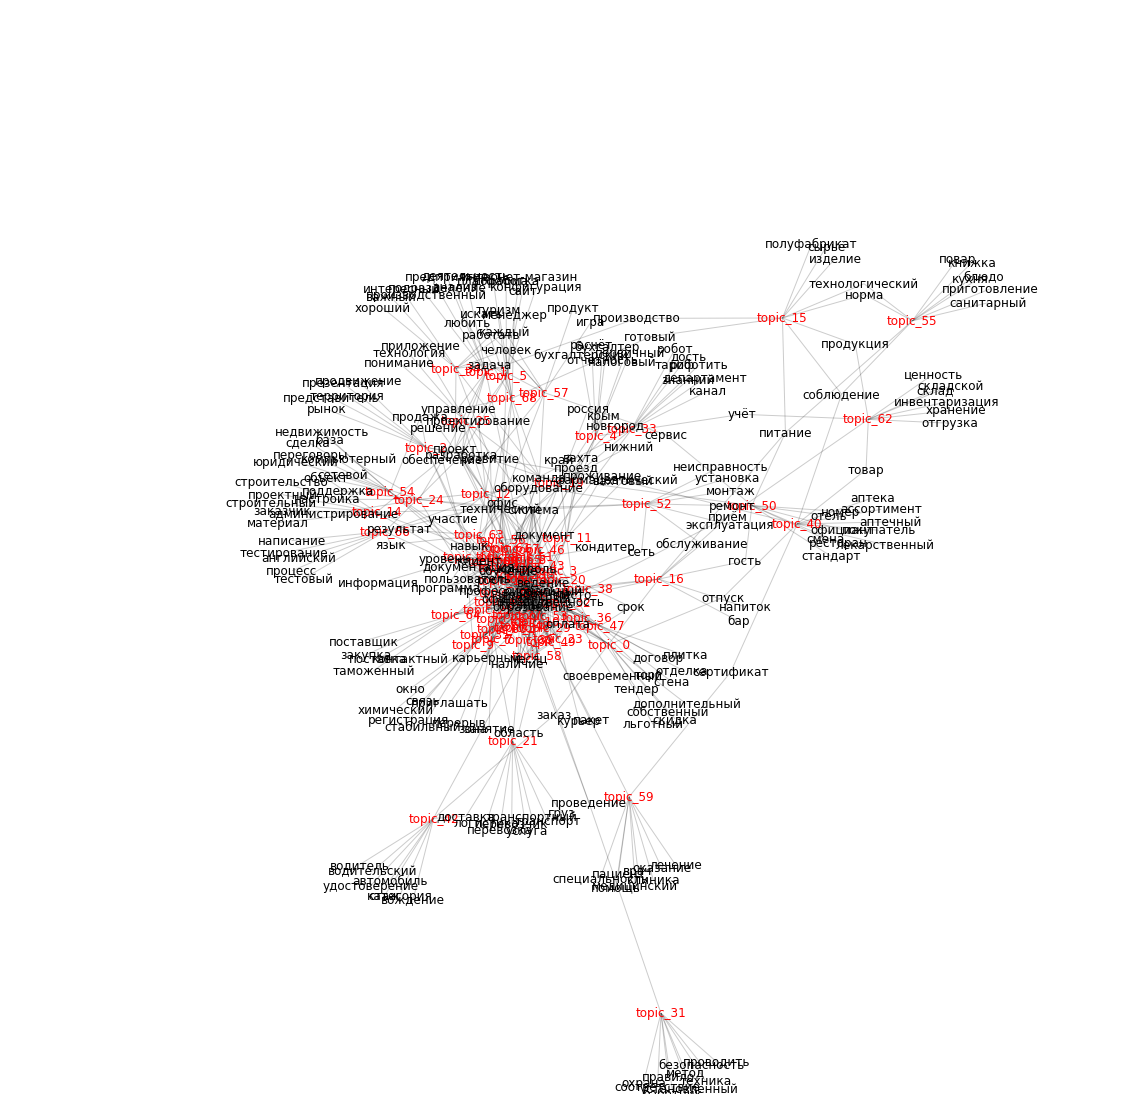

In [482]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
plt.figure(figsize=(20, 20))
f = G.subgraph([topic for topic,_ in pos.items() if 'topic_' in topic])
nx.draw_networkx_labels(f, pos, font_color='r')
f = G.subgraph([topic for topic,_ in pos.items() if 'topic_' not in topic])
nx.draw_networkx_labels(f, pos)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), alpha=0.2)
plt.axis('off')
plt.ylim(-1, 1)
plt.xlim(-1, 1)

In [483]:
topics_test = matutils.corpus2dense(model_test[corpus_test], num_terms=model_test.num_topics)

In [484]:
topics_test = topics_test.T

In [485]:
topics_test.shape

(31064, 70)

In [486]:
topics_test[77]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.25974998,
       0.04073074, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02502637,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02142972, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02273411, 0.        , 0.05620998, 0.        , 0.01210545,
       0.        , 0.        , 0.11531232, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03269506, 0.        ,
       0.        , 0.01224673, 0.        , 0.        , 0.        ],
      dtype=float32)

In [596]:
df_test_vectorized = tfidf2.transform(df_test['NText'])
df_test_vectorized.shape

(31064, 42247)

In [597]:
#df_test_vectorized = [text_to_vec(text) for text in df_test['NText']]

In [598]:
from scipy import sparse
As_test = sparse.csr_matrix(topics_test)
As_test.shape

(31064, 70)

In [599]:
from scipy.sparse import hstack
df_test_vectorized = hstack((df_test_vectorized, As_test))
df_test_vectorized.shape

(31064, 42317)

In [600]:
final_model = LinearSVC(C=1)

In [601]:
final_model.fit(X, y)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [503]:
pred = final_model.predict(df_test_vectorized)
pred

array([3, 2, 5, ..., 0, 4, 5])

## Submition

In [504]:
pd.DataFrame(zip(df_test.index, pred), columns = ['id','target']).to_csv('pred_hw10.csv', sep=',', index=False)

## Memory Monitoring

In [602]:
# какие десять переменных занимают больше всего памяти
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      df_train: 125.4 MiB
                       df_test: 124.1 MiB
                      tmp_dict:  5.0 MiB
                     tmp_dict2:  5.0 MiB
                 all_sentences:  3.4 MiB
                index2word_set:  2.0 MiB
                             y:  1.7 MiB
                      w2v_dict:  1.3 MiB
                       y_train: 339.8 KiB
                         nones: 288.1 KiB


In [603]:
def reduce_mem_usage(df):
    """ function by Bartosz Mikulski
        https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
    if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [604]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 2.20 MB
Memory usage after optimization is: 2.20 MB
Decreased by 0.0%
Memory usage of dataframe is 0.71 MB
Memory usage after optimization is: 0.71 MB
Decreased by 0.0%


In [605]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
